# Week-ahead Prediction Accuracy

In this notebook I hope to illustrate the differences between week-ahead prediction accuracies for Random Forest models trained in the same way on 2022-2023 data.

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tscv import GapRollForward
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('../data/merged_interpolated.csv')
df.datetime = df.datetime.astype('datetime64')
df.head()

,datetime,tempc,cloud8,windk,wdir,humid,rainmm,radkjm2,pv_est,net_load,total_load
0,2018-03-06 09:30:00,20.75,2.5,14.5,135.0,44.5,0.0,1915.0,318.991,1288,1136.79
1,2018-03-06 10:00:00,21.50,1.0,16.0,140.0,40.0,0.0,2340.0,375.231,1237,1054.87
2,2018-03-06 10:30:00,22.25,1.5,15.5,145.0,37.0,0.0,2570.0,430.909,1189,1002.35
3,2018-03-06 11:00:00,23.00,2.0,15.0,150.0,34.0,0.0,2800.0,485.129,1150,971.54
4,2018-03-06 11:30:00,23.55,2.0,13.0,145.0,32.0,0.0,2945.0,523.989,1122,943.68


Expand datetime feature to its various component parts, plus day of week and week of year.

In [3]:
dt = df['datetime'].astype('datetime64[ns]').dt
df['year'] = dt.year
df['month'] = dt.month
df['day'] = dt.day
df['hour'] = dt.hour
df['minute'] = dt.minute
df['day_of_week'] = dt.day_of_week
df['week'] = dt.isocalendar().week
df.dtypes

datetime       datetime64[ns]
tempc                 float64
cloud8                float64
windk                 float64
wdir                  float64
humid                 float64
rainmm                float64
radkjm2               float64
pv_est                float64
net_load                int64
total_load            float64
year                    int64
month                   int64
day                     int64
hour                    int64
minute                  int64
day_of_week             int64
week                   UInt32
dtype: object

Select training features and extract training matrix X and response y.

In [4]:
X_inds = list(range(1, 8)) + list(range(11, 18))
y_ind = 9
X = df.iloc[:, X_inds].to_numpy()
y = df.iloc[:, 9].to_numpy()

print(X.shape, y.shape)
df.columns[X_inds], df.columns[y_ind]

(87726, 14) (87726,)


(Index(['tempc', 'cloud8', 'windk', 'wdir', 'humid', 'rainmm', 'radkjm2',
        'year', 'month', 'day', 'hour', 'minute', 'day_of_week', 'week'],
       dtype='object'),
 'net_load')

Cross-validation splits are done in an appropriate time-series fashion, with one observation-year (48 observations \* 365 days) for each training set and test set. There should be a good number of splits with a roll size (gap between successive training set starting points) of 30 days.

In [5]:
obs_year = 48*365
obs_week = 48*7
tscv = GapRollForward(min_train_size=obs_year, max_train_size=obs_year,
                      min_test_size=obs_week, max_test_size=obs_week,
                      roll_size=48)

df_2022 = df[df['year'] >= 2022]
n_splits = sum(1 for i in tscv.split(df_2022)) # get length of a generator

print('Number of models to be trained:', n_splits)

Number of models to be trained: 60


Training of each forest is parallelised to save time, but even so the full training takes a few minutes. No hyperparameters are selected or tuned. Models and their last training observation's timestamps are saved.

Predictions are made on a full ensuing year per model and merged into a single dataframe, with calculated residuals and absolute percentage error.

In [6]:
models, train_ends = [], []
prdfs = []

for i, (train_ind, test_ind) in tqdm(enumerate(tscv.split(df_2022))):
    X_train, X_test = df_2022.iloc[train_ind, X_inds], df_2022.iloc[test_ind, X_inds]
    y_train, y_test = df_2022.iloc[train_ind, y_ind], df_2022.iloc[test_ind, y_ind]

    # train
    rf = RandomForestRegressor(n_jobs=8)
    rf.fit(X_train, y_train)
    models.append(rf)
    train_ends.append(df_2022.iloc[train_ind[-1], 0])

    # predict
    prd = rf.predict(X_test)
    prdf = pd.DataFrame({'datetime': df_2022.iloc[test_ind, 0], 
                        'model': i,
                        'obs_ahead': np.arange(len(prd)) + 1,
                        'predicted': prd,
                        'net_load': df_2022.iloc[test_ind, 9]})
    prdfs.append(prdf)
predictions = pd.concat(prdfs)
predictions['residual'] = predictions['net_load'] - predictions['predicted']
predictions['ape'] = predictions['residual'].abs() / predictions['net_load']
predictions

0it [00:00, ?it/s]

,datetime,model,obs_ahead,predicted,net_load,residual,ape
84557,2023-01-01 00:00:00,0,1,1602.96,1472,-130.96,0.088967
84558,2023-01-01 00:30:00,0,2,1550.04,1456,-94.04,0.064588
84559,2023-01-01 01:00:00,0,3,1536.32,1446,-90.32,0.062462
84560,2023-01-01 01:30:00,0,4,1524.67,1402,-122.67,0.087496
84561,2023-01-01 02:00:00,0,5,1363.20,1329,-34.20,0.025734
...,...,...,...,...,...,...,...
87720,2023-03-07 21:30:00,59,332,1510.31,1500,-10.31,0.006873
87721,2023-03-07 22:00:00,59,333,1438.06,1464,25.94,0.017719
87722,2023-03-07 22:30:00,59,334,1417.35,1406,-11.35,0.008073
87723,2023-03-07 23:00:00,59,335,1382.15,1373,-9.15,0.006664


Demonstrate model prediction windows.

In [30]:
for i in range(3):
    print(i)
    print(predictions.loc[predictions['model'] == i, 'datetime'].describe()[['first', 'last']])

0
first    2023-01-01 00:00:00
last     2023-01-07 23:30:00
Name: datetime, dtype: object
1
first    2023-01-02 00:00:00
last     2023-01-08 23:30:00
Name: datetime, dtype: object
2
first    2023-01-03 00:00:00
last     2023-01-09 23:30:00
Name: datetime, dtype: object


/var/folders/q1/x9cngnlj2pdglh47tvmrz2s40000gn/T/ipykernel_55752/408809817.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(predictions.loc[predictions['model'] == i, 'datetime'].describe()[['first', 'last']])
/var/folders/q1/x9cngnlj2pdglh47tvmrz2s40000gn/T/ipykernel_55752/408809817.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(predictions.loc[predictions['model'] == i, 'datetime'].describe()[['first', 'last']])
/var/folders/q1/x9cngnlj2pdglh47tvmrz2s40000gn/T/ipykernel_55752/408809817.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in

Plot absolute percentage error quartiles over time/models.

<Axes: xlabel='model'>

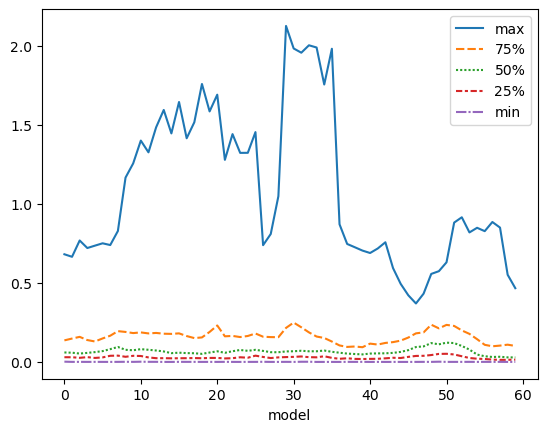

In [7]:
sns.lineplot(predictions.groupby('model').describe()['ape'][['max', '75%', '50%', '25%', 'min']])

Plot residual quantiles over time/models.

<Axes: xlabel='model'>

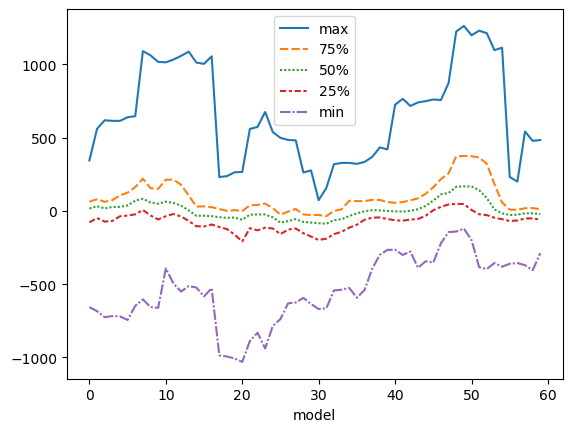

In [8]:
sns.lineplot(predictions.groupby('model').describe()['residual'][['max', '75%', '50%', '25%', 'min']])

<Axes: xlabel='model'>

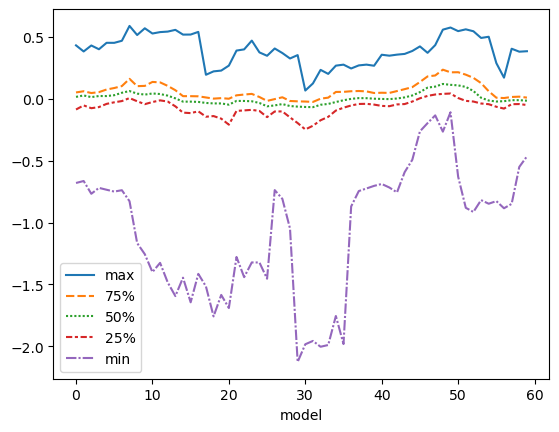

In [9]:
predictions['pe'] = predictions['residual'] / predictions['net_load']
sns.lineplot(predictions.groupby('model').describe()['pe'][['max', '75%', '50%', '25%', 'min']])

<Axes: xlabel='model'>

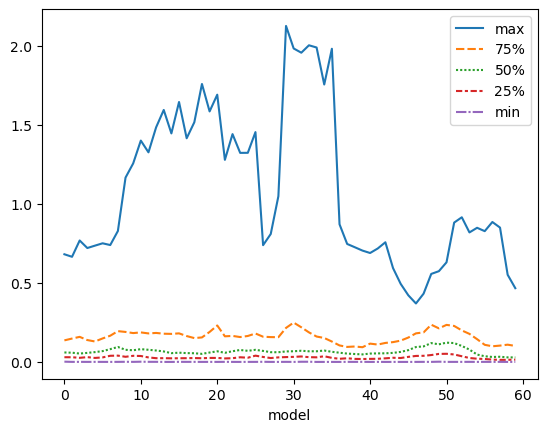

In [12]:
sns.lineplot(predictions.groupby('model').describe()['ape'][['max', '75%', '50%', '25%', 'min']])

<Axes: xlabel='datetime'>

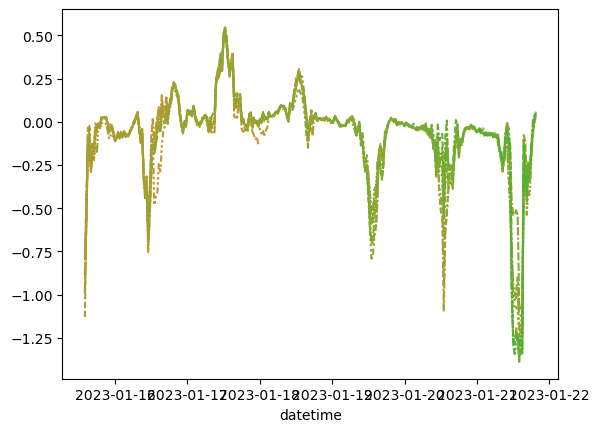

In [31]:
per_model_pe = predictions.pivot(index='datetime', columns='model', values='pe')
sns.lineplot(per_model_pe.iloc[700:1000,], legend=False)

Use all models to predict the final week of observations.

In [13]:
test_cutoff = df['datetime'].max() - pd.DateOffset(weeks=1)

final_week = df[df['datetime'] >= test_cutoff]

prdfs = []
for i, rf in enumerate(models):
    prd = rf.predict(final_week.iloc[:, X_inds])
    prdf = pd.DataFrame({'datetime': final_week['datetime'], 
                        'model': i,
                        'ahead': final_week['datetime'] - train_ends[i],
                        'predicted': prd,
                        'net_load': final_week['net_load']})
    prdfs.append(prdf)

final_week_prds = pd.concat(prdfs)
final_week_prds['residual'] = final_week_prds['net_load'] - final_week_prds['predicted']
final_week_prds['ape'] = final_week_prds['residual'].abs() / final_week_prds['net_load']
final_week_prds


,datetime,model,ahead,predicted,net_load,residual,ape
87389,2023-03-01 00:00:00,0,59 days 00:30:00,1492.03,1402,-90.03,0.064215
87390,2023-03-01 00:30:00,0,59 days 01:00:00,1486.56,1401,-85.56,0.061071
87391,2023-03-01 01:00:00,0,59 days 01:30:00,1471.78,1412,-59.78,0.042337
87392,2023-03-01 01:30:00,0,59 days 02:00:00,1429.95,1374,-55.95,0.040721
87393,2023-03-01 02:00:00,0,59 days 02:30:00,1362.12,1315,-47.12,0.035833
...,...,...,...,...,...,...,...
87721,2023-03-07 22:00:00,59,6 days 22:30:00,1438.06,1464,25.94,0.017719
87722,2023-03-07 22:30:00,59,6 days 23:00:00,1417.35,1406,-11.35,0.008073
87723,2023-03-07 23:00:00,59,6 days 23:30:00,1382.15,1373,-9.15,0.006664
87724,2023-03-07 23:30:00,59,7 days 00:00:00,1375.41,1364,-11.41,0.008365


<Axes: xlabel='model'>

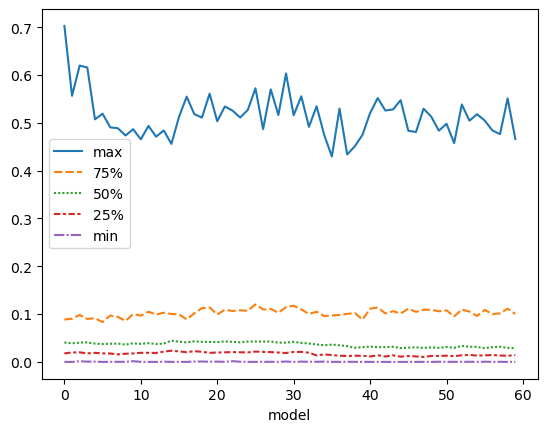

In [14]:
sns.lineplot(final_week_prds.groupby('model').describe()['ape'][['max', '75%', '50%', '25%', 'min']])

<Axes: xlabel='model'>

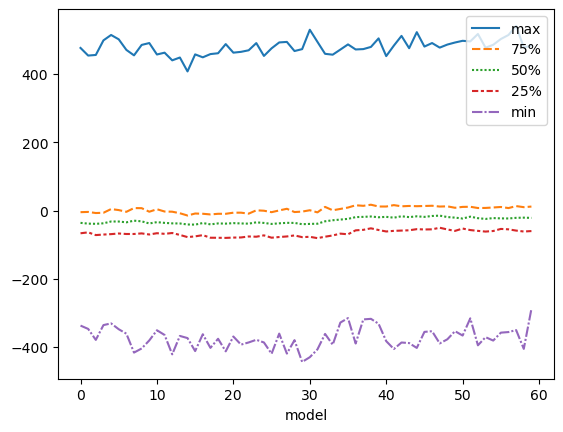

In [15]:
sns.lineplot(final_week_prds.groupby('model').describe()['residual'][['max', '75%', '50%', '25%', 'min']])